<a href="https://colab.research.google.com/github/muajnstu/DSK-Chain-to-predict-diabeties-/blob/main/Diabetics_Prediction_on_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Primary data

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#from sklearn.metrics import (accuracy_score, confusion_matrix, roc_auc_score, f1_score)
from sklearn.metrics import (confusion_matrix, accuracy_score, f1_score, roc_auc_score, recall_score, precision_score)
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors
from imblearn.over_sampling import SMOTE
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
import shap
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv('https://raw.githubusercontent.com/muajnstu/Comparative-Analysis-of-K-Nearest-Neighbors-Variants-for-Diabetes-Prediction-Using-Administrative-He/refs/heads/main/raw%20data.csv')
X = df.drop(columns=['Outcome'])
y = df['Outcome']

In [4]:
df.shape

(14222, 29)

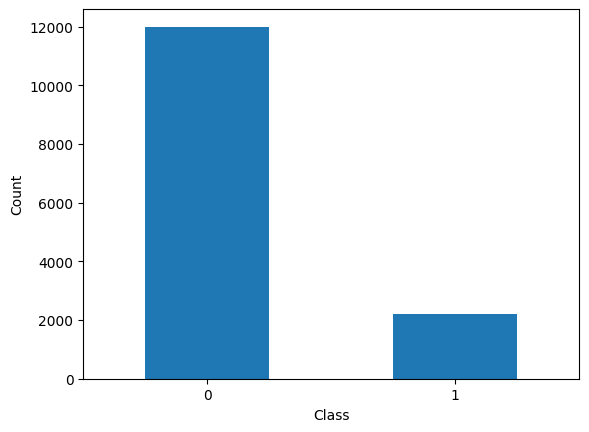

In [ ]:
y.value_counts().plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['0', '1'], rotation=0)
plt.show()

In [ ]:
# --- Custom Hybrid KNN+SVM (with memberships) ---
class KNNSVM(BaseEstimator, ClassifierMixin):
    def __init__(self, k=3, plot=True):
        self.k = k
        self.plot = plot

    def fit(self, X, y=None):
        # Convert X to numpy array if it's a pandas DataFrame
        if isinstance(X, pd.DataFrame):
            X_np = X.values
        else:
            X_np = X

        self.neigh = neighbors.NearestNeighbors(n_neighbors=14)
        self.neigh.fit(X_np, y)
        self._check_params(X_np, y)
        self.X = X_np
        self.y = y
        self.xdim = self.X.shape[1]
        self.n = len(y)
        self.classes = np.unique(y)
        self.df = pd.DataFrame(self.X)
        self.df['y'] = self.y.values
        self.memberships = self._compute_memberships()
        self.df['membership'] = self.memberships
        self.result = self.neigh.kneighbors(self.X)
        self.label_index = self.result[1]
        self.label = []
        self.train = []
        for i in self.label_index:
            for j in i:
                one_label = self.y.iloc[j]
                one_train = self.X[j]
                self.label.append(one_label)
                self.train.append(one_train)
        self.np_label = np.array(self.label)
        self.np_train = np.array(self.train)
        self.clf = LinearSVC()
        self.clf.fit(self.np_train, self.np_label)
        self.fitted_ = True
        return self

    def predict(self, r):
        if not hasattr(self, "fitted_") or not self.fitted_:
            raise Exception('predict() called before fit()')
        # Convert r to numpy array if it's a pandas DataFrame
        if isinstance(r, pd.DataFrame):
            r_np = r.values
        else:
            r_np = r

        if len(set(self.label)) == 1:
            return np.full(r_np.shape[0], self.label[0]) # Return array of the single class
        return self.clf.predict(r_np)

    def predict_proba(self, X):
        # LinearSVC does not have predict_proba; use decision_function instead
        if not hasattr(self, "fitted_") or not self.fitted_:
            raise Exception('predict_proba() called before fit()')
        # Convert X to numpy array if it's a pandas DataFrame
        if isinstance(X, pd.DataFrame):
            X_np = X.values
        else:
            X_np = X

        if hasattr(self.clf, "decision_function"):
            decision = self.clf.decision_function(X_np)
            # Normalize to (0,1) range for ROC AUC, shape (n_samples, n_classes)
            if decision.ndim == 1:
                # Binary case
                min_val, max_val = decision.min(), decision.max()
                if min_val == max_val:
                    probs = np.ones((len(decision), 2)) * 0.5
                else:
                    probs = np.zeros((len(decision), 2))
                    probs[:, 1] = (decision - min_val) / (max_val - min_val)
                    probs[:, 0] = 1 - probs[:, 1]
                return probs
            else:
                # Multiclass case
                exp_decision = np.exp(decision)
                probs = exp_decision / exp_decision.sum(axis=1, keepdims=True)
                return probs
        else:
            n = X_np.shape[0]
            # Return uniform probabilities if decision_function is not available
            return np.ones((n, len(self.classes))) / len(self.classes)


    def score(self, X, y):
        if not hasattr(self, "fitted_") or not self.fitted_:
            raise Exception('score() called before fit()')
        predictions = self.predict(X)
        predictions = np.asarray(predictions)
        return accuracy_score(y_pred=predictions, y_true=y)

    def _find_k_nearest_neighbors(self, df, x):
        X = df.iloc[:, 0:self.xdim].values
        df['distances'] = [np.linalg.norm(X[i] - x) for i in range(len(df))] # Use len(df) instead of self.n
        df.sort_values(by='distances', ascending=True, inplace=True)
        neighbors = df.iloc[0:self.k]
        return neighbors

    def _get_counts(self, neighbors):
        groups = neighbors.groupby('y')
        counts = {group[1]['y'].iloc[0]: group[1].count()[0] for group in groups}
        return counts

    def _compute_memberships(self):
        memberships = []
        for i in range(self.n):
            x = self.X[i]
            y = self.y.iloc[i] # Access using integer position
            neighbors = self._find_k_nearest_neighbors(pd.DataFrame.copy(self.df), x)
            counts = self._get_counts(neighbors)
            membership = dict()
            for c in self.classes:
                uci = 0.49 * (counts.get(c, 0) / self.k)
                if c == y:
                    uci += 0.51
                membership[c] = uci
            memberships.append(membership)
        return memberships

    def _check_params(self, X, y):
        if type(self.k) != int:
            raise Exception('"k" should have type int')
        elif self.k >= X.shape[0]: # Check against number of samples
            raise Exception('"k" should be less than no of feature sets')
        elif self.k % 2 == 0:
            raise Exception('"k" should be odd')
        if type(self.plot) != bool:
            raise Exception('"plot" should have type bool')


# --- Custom Hybrid KNN+Bayes (with memberships) ---
class KNNBayes(BaseEstimator, ClassifierMixin):
    def __init__(self, k=3, plot=True):
        self.k = k
        self.plot = plot

    def fit(self, X, y=None):
        # Convert X to numpy array if it's a pandas DataFrame
        if isinstance(X, pd.DataFrame):
            X_np = X.values
        else:
            X_np = X

        self.neigh = neighbors.NearestNeighbors(n_neighbors=14)
        self.neigh.fit(X_np, y)
        self._check_params(X_np, y) # Pass numpy array to check_params
        self.X = X_np
        self.y = y
        self.xdim = self.X.shape[1] # Use shape for dimensions
        self.n = len(y)
        self.classes = np.unique(y) # Get classes from y
        self.df = pd.DataFrame(self.X)
        self.df['y'] = self.y.values # Use .values to get numpy array for alignment
        self.memberships = self._compute_memberships()
        self.df['membership'] = self.memberships
        self.result = self.neigh.kneighbors(self.X)
        self.label_index = self.result[1]
        self.label = []
        self.train = []
        for i in self.label_index:
            for j in i:
                one_label = self.y.iloc[j] # Access using integer position
                one_train = self.X[j] # Access using numpy indexing
                self.label.append(one_label)
                self.train.append(one_train)
        self.np_label = np.array(self.label)
        self.np_train = np.array(self.train)
        self.clf = GaussianNB()
        self.clf.fit(self.np_train, self.np_label)
        self.fitted_ = True
        return self

    def predict(self, r):
        if not hasattr(self, "fitted_") or not self.fitted_:
            raise Exception('predict() called before fit()')
        # Convert r to numpy array if it's a pandas DataFrame
        if isinstance(r, pd.DataFrame):
            r_np = r.values
        else:
            r_np = r

        if len(set(self.label)) == 1:
             return np.full(r_np.shape[0], self.label[0]) # Return array of the single class

        return self.clf.predict(r_np)

    def predict_proba(self, X):
        if not hasattr(self, "fitted_") or not self.fitted_:
            raise Exception('predict_proba() called before fit()')
        # Convert X to numpy array if it's a pandas DataFrame
        if isinstance(X, pd.DataFrame):
            X_np = X.values
        else:
            X_np = X

        return self.clf.predict_proba(X_np)

    def score(self, X, y):
        if not hasattr(self, "fitted_") or not self.fitted_:
            raise Exception('score() called before fit()')
        predictions = self.predict(X)
        predictions = np.asarray(predictions)
        return accuracy_score(y_pred=predictions, y_true=y)

    def _find_k_nearest_neighbors(self, df, x):
        X = df.iloc[:, 0:self.xdim].values
        df['distances'] = [np.linalg.norm(X[i] - x) for i in range(len(df))] # Use len(df) instead of self.n
        df.sort_values(by='distances', ascending=True, inplace=True)
        neighbors = df.iloc[0:self.k]
        return neighbors

    def _get_counts(self, neighbors):
        groups = neighbors.groupby('y')
        counts = {group[1]['y'].iloc[0]: group[1].count()[0] for group in groups}
        return counts

    def _compute_memberships(self):
        memberships = []
        for i in range(self.n):
            x = self.X[i]
            y = self.y.iloc[i] # Access using integer position
            neighbors = self._find_k_nearest_neighbors(pd.DataFrame.copy(self.df), x)
            counts = self._get_counts(neighbors)
            membership = dict()
            for c in self.classes:
                uci = 0.49 * (counts.get(c, 0) / self.k)
                if c == y:
                    uci += 0.51
                membership[c] = uci
            memberships.append(membership)
        return memberships

    def _check_params(self, X, y):
        if type(self.k) != int:
            raise Exception('"k" should have type int')
        elif self.k >= X.shape[0]: # Check against number of samples
            raise Exception('"k" should be less than no of feature sets')
        elif self.k % 2 == 0:
            raise Exception('"k" should be odd')
        if type(self.plot) != bool:
            raise Exception('"plot" should have type bool')


class KmeansKNN():
    def __init__(self, n_neighbors=3, output='add', n_jobs=None, random_state=0):
        self.output = output
        self._random_state = random_state
        self._cluster = None
        self._kclass = KNeighborsClassifier(n_neighbors=n_neighbors, n_jobs=n_jobs)

    def fit(self, X_train, y_train):
        if type(X_train) != np.ndarray:
            X_train = X_train.values
        self._cluster = KMeans(n_clusters=len(np.unique(y_train)), random_state=self._random_state, n_init=10).fit(X_train) # Added n_init
        y_labels_train = self._cluster.labels_
        if self.output == 'add':
            X_train = np.append(X_train, np.reshape(y_labels_train, (-1, 1)), axis=1)
        elif self.output == 'replace':
            X_train = y_labels_train[:, np.newaxis]
        else:
            raise ValueError('output should be either add or replace')
        self._kclass.fit(X_train, y_train)

    def predict(self, X_test):
        if type(X_test) != np.ndarray:
            X_test = X_test.values
        y_labels_test = self._cluster.predict(X_test)
        if self.output == 'add':
            X_test = np.append(X_test, np.reshape(y_labels_test, (-1, 1)), axis=1)
        elif self.output == 'replace':
            X_test = y_labels_test[:, np.newaxis]
        else:
            raise ValueError('output should be either add or replace')
        return self._kclass.predict(X_test)

    def predict_proba(self, X_test):
        if type(X_test) != np.ndarray:
            X_test = X_test.values
        y_labels_test = self._cluster.predict(X_test)
        if self.output == 'add':
            X_test = np.append(X_test, np.reshape(y_labels_test, (-1, 1)), axis=1)
        elif self.output == 'replace':
            X_test = y_labels_test[:, np.newaxis]
        else:
            raise ValueError('output should be either add or replace')
        return self._kclass.predict_proba(X_test)

In [ ]:
def print_metrics(y_true, y_pred, y_prob=None):
    cm = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)

    num_classes = cm.shape[0]

    if num_classes == 2:
        # Binary classification
        TN, FP, FN, TP = cm.ravel()
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
        gmean = np.sqrt(specificity * sensitivity)
        type1 = FP / (FP + TN) if (FP + TN) > 0 else 0
        type2 = FN / (TP + FN) if (TP + FN) > 0 else 0
        fmeasure = f1_score(y_true, y_pred, pos_label=1)
        auc = 0
        if y_prob is not None and hasattr(y_prob, "shape") and y_prob.shape[1] > 1:
            try:
                auc = roc_auc_score(y_true, y_prob[:, 1])
            except Exception:
                auc = 0

    else:
        # Multiclass classification
        TP = np.diag(cm)
        FP = np.sum(cm, axis=0) - TP
        FN = np.sum(cm, axis=1) - TP
        TN = np.sum(cm) - (FP + FN + TP)

        specificity = np.mean([
            TN[i] / (TN[i] + FP[i]) if (TN[i] + FP[i]) > 0 else 0 for i in range(num_classes)
        ])
        sensitivity = np.mean([
            TP[i] / (TP[i] + FN[i]) if (TP[i] + FN[i]) > 0 else 0 for i in range(num_classes)
        ])
        gmean = np.sqrt(specificity * sensitivity)
        type1 = np.mean([
            FP[i] / (FP[i] + TN[i]) if (FP[i] + TN[i]) > 0 else 0 for i in range(num_classes)
        ])
        type2 = np.mean([
            FN[i] / (TP[i] + FN[i]) if (TP[i] + FN[i]) > 0 else 0 for i in range(num_classes)
        ])
        fmeasure = f1_score(y_true, y_pred, average='macro')

        auc = 0
        if y_prob is not None and hasattr(y_prob, "shape") and y_prob.shape[1] > 1:
            try:
                auc = roc_auc_score(y_true, y_prob, multi_class='ovr', average='macro')
            except Exception:
                auc = 0

    # Print or return results
    print(f"Accuracy      : {accuracy:.4f}")
    print(f"Sensitivity   : {sensitivity:.4f}")
    print(f"Specificity   : {specificity:.4f}")
    print(f"G-Mean        : {gmean:.4f}")
    print(f"Type I Error  : {type1:.4f}")
    print(f"Type II Error : {type2:.4f}")
    print(f"F1 Score      : {fmeasure:.4f}")
    print(f"AUROC         : {auc:.4f}")


In [ ]:
# --- KNN Variant Models ---
def run_knn_variant(name, knn_clf):
    print(f"\n==== {name} ====")
    knn_clf.fit(X_train, y_train)
    y_pred = knn_clf.predict(X_test)
    if hasattr(knn_clf, "predict_proba"):
        try:
            y_prob = knn_clf.predict_proba(X_test)
        except Exception:
            y_prob = None
    else:
        y_prob = None
    print_metrics(y_test, y_pred, y_prob)

In [ ]:
df=pd.read_csv('https://raw.githubusercontent.com/muajnstu/Comparative-Analysis-of-K-Nearest-Neighbors-Variants-for-Diabetes-Prediction-Using-Administrative-He/refs/heads/main/raw%20data.csv')
X = df.drop(columns=['Outcome'])
y = df['Outcome']

# --- Train/Test Split ---

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=46, stratify=y)


In [ ]:
# Recalculate covariance and variance with the current X_train after SMOTE
covariance_matrix = np.cov(X_train.T)
stabilized_covariance_matrix = covariance_matrix + np.eye(covariance_matrix.shape[0]) * 1e-6
inv_covariance_matrix = np.linalg.inv(stabilized_covariance_matrix)
variance_vector = np.var(X_train, axis=0)

knn_variants = {
    "KNN": KNeighborsClassifier(n_neighbors=3),
    "DistanceKNN": KNeighborsClassifier(n_neighbors=3, weights='distance'),
    "GeneralizedKNN": KNeighborsClassifier(n_neighbors=3, metric='minkowski', p=3),
    "EuclideanKNN": KNeighborsClassifier(n_neighbors=3, metric='euclidean'),
    "ManhattanKNN": KNeighborsClassifier(n_neighbors=3, metric='manhattan'),
    "ChebyshevKNN": KNeighborsClassifier(n_neighbors=3, metric='chebyshev'),
    # Use the recalculated inverse covariance matrix and variance vector
    "MahalanobisKNN": KNeighborsClassifier(n_neighbors=3, metric='mahalanobis', metric_params={'VI': inv_covariance_matrix}),
    "SeuclideanKNN": KNeighborsClassifier(n_neighbors=3, metric='seuclidean', metric_params={'V': variance_vector}),
    "WminkowskiKNN": KNeighborsClassifier(n_neighbors=3, metric='minkowski', p=3, metric_params={'w': np.ones(X_train.shape[1])}),
    #"KNNBayes": KNNBayes(k=3, plot=False),
    #"KNNSVM": KNNSVM(k=3, plot=False)
}


for name, model in knn_variants.items():
    run_knn_variant(name, model)

#print("\n==== KMeansKNN ====")
#kmeansknn = KmeansKNN(n_neighbors=3, output='add')
#kmeansknn.fit(X_train, y_train)
#y_pred = kmeansknn.predict(X_test)
#y_prob = kmeansknn.predict_proba(X_test)
#print_metrics(y_test, y_pred, y_prob)

print("\nProject complete! Check the above output for performance of each KNN variant.")


==== KNN ====
Accuracy      : 0.8155
Sensitivity   : 0.1104
Specificity   : 0.9459
G-Mean        : 0.3231
Type I Error  : 0.0541
Type II Error : 0.8896
F1 Score      : 0.1573
AUROC         : 0.5516

==== DistanceKNN ====
Accuracy      : 0.8077
Sensitivity   : 0.1081
Specificity   : 0.9371
G-Mean        : 0.3183
Type I Error  : 0.0629
Type II Error : 0.8919
F1 Score      : 0.1493
AUROC         : 0.5420

==== GeneralizedKNN ====
Accuracy      : 0.8011
Sensitivity   : 0.1374
Specificity   : 0.9238
G-Mean        : 0.3563
Type I Error  : 0.0762
Type II Error : 0.8626
F1 Score      : 0.1773
AUROC         : 0.5585

==== EuclideanKNN ====
Accuracy      : 0.8155
Sensitivity   : 0.1104
Specificity   : 0.9459
G-Mean        : 0.3231
Type I Error  : 0.0541
Type II Error : 0.8896
F1 Score      : 0.1573
AUROC         : 0.5516

==== ManhattanKNN ====
Accuracy      : 0.8165
Sensitivity   : 0.1059
Specificity   : 0.9479
G-Mean        : 0.3168
Type I Error  : 0.0521
Type II Error : 0.8941
F1 Score      